# Appendix A4: Bessel low-pass filters
**Appendix A provides extra background for path clamp electronics.**

[Bessel filters](https://en.wikipedia.org/wiki/Bessel_filter) are popular for low-pass filtering in patch clamp hardware.
Compared to other filter types, they have very little _overshoot_: when you pass a voltage step through a Bessel filter it gets smoothed, but the filtered voltage _almost_ doesn't go beyond the intended step (graphs below!).

In this notebook, we build on the concepts reviewed in [Appendix A2](./appendix-A2-laplace-and-filters.ipynb) to explore Bessel filters in detail.

## Transfer function

The transfer function for a Bessel low-pass filter has a [reverse Bessel polynomial](https://en.wikipedia.org/wiki/Bessel_polynomials) as its denominator, and a numerator which acts as a scaling term to achieve unity gain for $s = 0$.

In mathematical notation, a Bessel low-pass filter of **order $n$** has transfer function:

\begin{align}
H(s) = \frac{\theta_n(0)}{\theta_n(s)}
\end{align}
where
\begin{align}
\theta_n(x) = \sum_{k=0}^{n} \frac{(2n - k)!}{2^{n-k}(n - k)!k!} x^k
            = \sum_{k=0}^{n} \alpha_{n,k} x^{n-k}
\end{align}

For example, a third order Bessel filter has transfer function
\begin{align}
H(s) = \frac{\alpha_{3, 0}}{\alpha_{3, 3} s^3 + \alpha_{3, 2} s^2 + \alpha_{3, 1} s + \alpha_{3, 0}}
\end{align}
where $\alpha_{3, 0}=15$, $\alpha_{3, 1}=15$, $\alpha_{3, 2}=6$, and $\alpha_{3, 0}=1$ for
\begin{align}
H(s) = \frac{15}{s^3 + 6s^2 + 15s + 15}
\end{align}

### Example transfer functions

Finding $\alpha_{n,k}$ is easiest with a script:

In [1]:
import math
import numpy as np

def revbes(n):
    """ Returns the coefficients for a reverse Bessel polynomial. """
    f = math.factorial
    return [int(f(2 * n - k) / (2**(n - k)*f(n - k) * f(k)))
            for k in range(n + 1)]
    
print(revbes(3))

[15, 15, 6, 1]


This lets us find the first six filters as:

In [2]:
for i in range(1, 7):
    print(i, revbes(i))

1 [1, 1]
2 [3, 3, 1]
3 [15, 15, 6, 1]
4 [105, 105, 45, 10, 1]
5 [945, 945, 420, 105, 15, 1]
6 [10395, 10395, 4725, 1260, 210, 21, 1]


\begin{align}
H_1(s) &= \frac{1}{s + 1} \\
H_2(s) &= \frac{3}{s^2 + 3s + 3} \\
H_3(s) &= \frac{15}{s^3 + 6s^2 + 15s + 15} \\
H_4(s) &= \frac{105}{s^4 + 10s^3 + 45s^2 + 105s + 105} \\
H_5(s) &= \frac{945}{s^5 + 15s^4 + 105s^3 + 420s^2 + 945s + 945} \\
H_6(s) &= \frac{10395}{s^6 + 21s^5 + 210s^4 + 1260s^3 + 4725s^2 + 10395s + 10395}
\end{align}

## The cut-off frequency

To design a Bessel filter with a particular cut-off frequency, we:

1. Decide on an _attenuation level_, for example the famous "3[dB](https://en.wikipedia.org/wiki/Decibel) point": $^{10}\log(1/2) \approx -3.01$.
2. Using $|H(i\omega)|$ to find a frequency $\omega$ where the filter has the desired attenuation (typically numerically, e.g. with root-finding).
3. Scale $s$.

## Poles
**Note**: Some sources say the poles lie on the unit circle: they do not.

To find the poles of a Bessel filter, we can use [partial fraction decomposition](https://en.wikipedia.org/wiki/Partial_fraction_decomposition) on the equations shown above.
We can also make life easier, and ask SciPy to approximate them numerically with the function [`scipy.signal.bessel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.bessel.html).

Unfortunately the function to do this has a lot of arguments. The main ones are:
- `N`: The order of the filter
- `Wn`: When `norm=phase` and `analog=True` this is the angular "critical frequency". To get solutions to the equations above, we use `Wn=1`
- `btype`: Filter type, we leave this at the default of `lowpass`.
- `analog`: In the above, we're assuming an analog filter, that is, a filter that operates on a continuous signal. Later we will set this to `digital` to create filters we can use on a sampled filter.
- `output`: Set this to `zpk` to obtain the zeroes (z), poles (p), and a gain factor (k).
- `delay`: Set this to `delay`, to get "the natural type obtained by solving Bessel polynomials".

Let's try for a filter with n=1:

In [3]:
import scipy.signal

z, p, k = scipy.signal.bessel(1, 1, output='zpk', analog=True, norm='delay')
print(z)
print(p)
print(k)

[]
[-1.-0.j]
1.0


So no zeroes, a pole at $s = -1$ and a gain factor $1$

For this filter we had
\begin{align}
H(s) &= \frac{1}{s + 1}
\end{align}
so this checks out!

Note that the lack of zeroes makes sense as well: we can see this directly from the original transfer function.

Now we can try for $n=2$:

In [4]:
z, p, k = scipy.signal.bessel(2, 1, output='zpk', analog=True, norm='delay')
print(p)
print(k)

[-1.5+0.8660254j -1.5-0.8660254j]
3.0


So no zeroes, a gain of 3, and poles at $-1.5 \pm i\sqrt{3}/2$ (where we did a bit of guesswork to equate 0.8660254 with $\sqrt{3}/2$).

Filling in, and using $(a - bi)(a + bi) = a^2 + b^2$, we find:
\begin{align}
H(s) &= \frac{3}{(s + 1.5 - i\sqrt{3}/2)(s + 1.5 + i\sqrt{3}/2)} \\
     &= \frac{3}{(s + 3/2)^2 + 3/4} \\
     &= \frac{3}{s^2 + 3s + 3} \\
\end{align}

We can go crazy and do it for the next one up:

In [5]:
z, p, k = scipy.signal.bessel(3, 1, output='zpk', analog=True, norm='delay')
print(p)
print(k)

[-1.83890732+1.75438096j -2.32218535-0.j         -1.83890732-1.75438096j]
15.0


Comparing with 
\begin{align}
H(s) &= \frac{15}{s^3 + 6s^2 + 15s + 15}
\end{align}
we can immediately see that the "gain" of 15 is correct.

Guessing what fractions 1.83890732, 1.75438096, and 2.32218535 approximate is harder, so instead we write out the equation for denominator $D$ symbolically, and then fill in $a\approx1.83890732$, $b\approx1.75438096$, and $c\approx2.32218535$:

\begin{align}
D &= (s + a - bi)(s + a + bi)(s + c) \\
  &= ((s + a)^2 + b^2))(s + c) \\
  &= (s^2 + a^2 + 2as + b^2)(s + c) \\
  &= s^3 + a^2s + 2as^2 + b^2s + cs^2 + a^2c + 2acs + b^2c \\
  &= s^3 + (2a + c)s^2 + (a^2 + b^2 + 2ac)s + c(a^2 + b^2)
\end{align}

In [6]:
a = -p[0].real
b = p[0].imag
c = -p[1].real

print(2*a + c)
print(a**2 + b**2 + 2*a*c)
print(c*(a**2 + b**2))

6.0
14.999999999999996
14.999999999999995


So these coefficients are within machine precision of 6, 15, 15 and this one again checks out!

## Frequency response and Bode plots

To work out a Bessel filter's frequency response we need to evaluate $|H(i\omega)|$ and $\angle H(i\omega)$.

Luckily, Python can do this for us.

In [7]:
def mag(w):
    x = 1j * w
    return np.abs(15 / (x**3 + 6*x**2 + 15*x + 15))
    
def arg(w):
    x = 1j * w
    return -np.angle(15 / (x**3 + 6*x**2 + 15*x + 15))

We can then use the method from [Appendix A2](./appendix-A2-laplace-and-filters) to create a Bode plot:

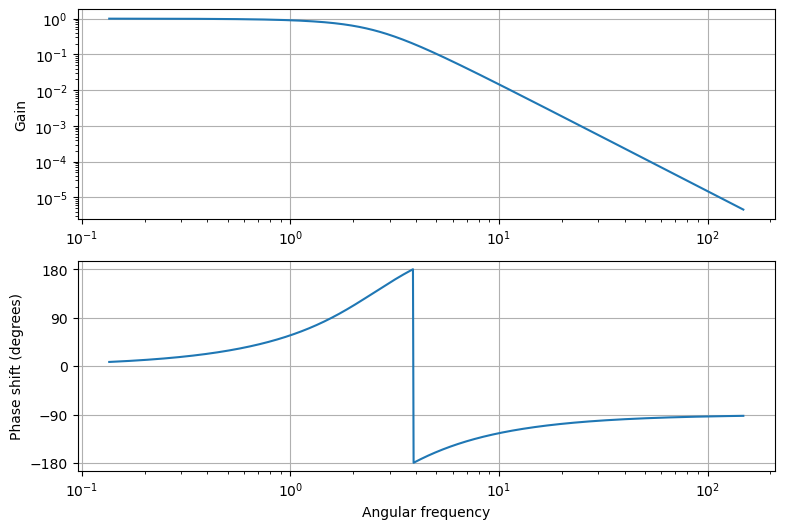

In [8]:
import matplotlib.pyplot as plt
from library import bode
axes = bode(mag, arg)
plt.show()    

Note that the vertical line at the center of the angular frequency plot shouldn't really be there: The phase shift just starts at 0 degrees and then increases, but by convention we call the shifts beyond 180 degrees negative shifts instead.

We can write the `mag` and `abs` methods to take an argument $n$ for order (or pole count).
(Although the example below is a very inefficient way to do this)

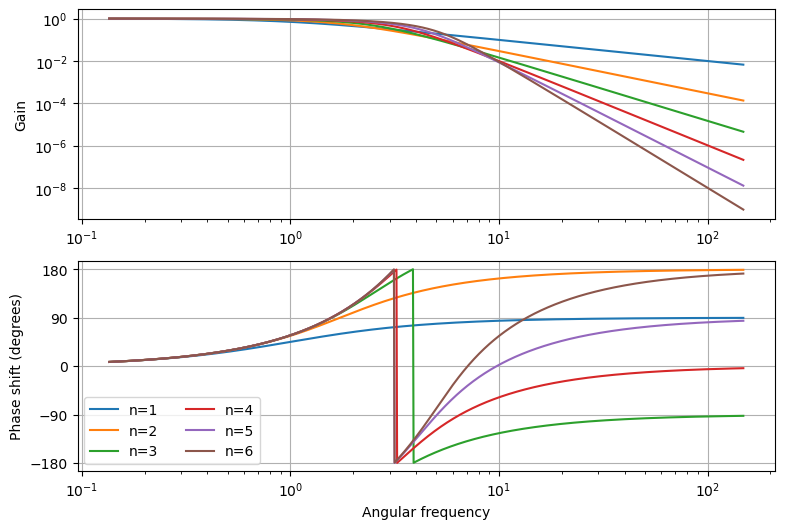

In [9]:
def bes(w, n):
    x = 1j * w
    a = revbes(n)
    b = np.array([x**i for i in range(1 + n)])
    return a[0] / np.sum(a * b.T, axis=1)

def mag(w, n):
    return np.abs(bes(w, n))
    
def arg(w, n):
    return -np.angle(bes(w, n))

axes = bode(mag, arg, n=1)
axes = bode(mag, arg, n=2, axes=axes)
axes = bode(mag, arg, n=3, axes=axes)
axes = bode(mag, arg, n=4, axes=axes)
axes = bode(mag, arg, n=5, axes=axes)
axes = bode(mag, arg, n=6, axes=axes)
axes[1].legend(loc='lower left', ncols=2)
plt.show()    

We can compare the top plot with the scipy version:

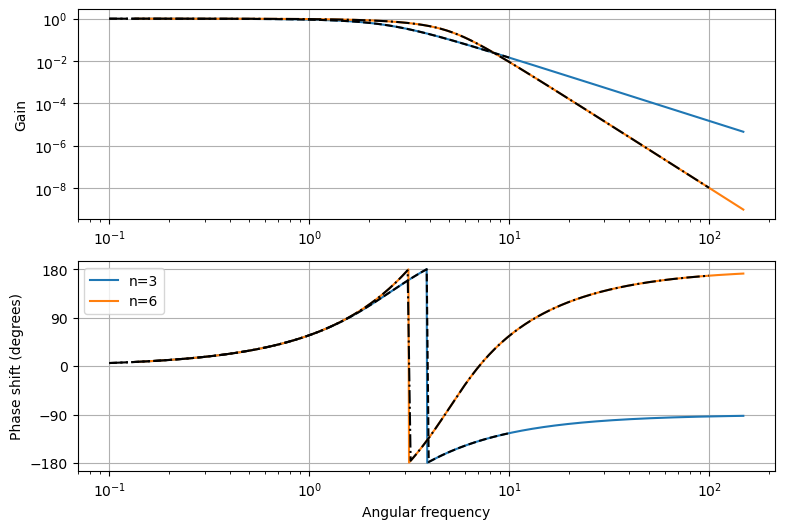

In [10]:
axes = bode(mag, arg, n=3)
axes = bode(mag, arg, n=6, axes=axes)
ax0, ax1 = axes

b, a = scipy.signal.bessel(3, 1, analog=True, norm='delay')
w, h = scipy.signal.freqs(b, a)
ax0.plot(w, np.abs(h), 'k--')
ax1.plot(w, -np.angle(h) * 180 / np.pi, 'k--')

b, a = scipy.signal.bessel(6, 1, analog=True, norm='delay')
w, h = scipy.signal.freqs(b, a)
ax0.plot(w, np.abs(h), 'k-.')
ax1.plot(w, -np.angle(h) * 180 / np.pi, 'k-.')

plt.show()

This confirms that the SciPy `bessel` function with `Wn=1`, `analog=True`, and `norm='delay'` is the canonical "Bessel filter" described by the transfer functions above.

## Emulating an analog filter

We can also use SciPy to simulate the effects of an analog filter (i.e. a fitler implemented in electronics) on an analog signal (some fluctuating voltage on a wire).

For this, we use the method [lsim](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lsim.html).

#### The `norm` argument again

Above, we used `Wn=1, norm='delay'` to obtain the poles of a filter without any scaling.
With these settings, `Wn` is interpreted as something related to "group delay", and using `Wn=1` just gives the normal scaling.

When applying a filter, we'll use `Wn=w, norm='mag'`.
With this setting, the filter is _normalised_ (hence `norm`) so that `Wn` becomes the cutoff point, i.e. the point at which $|H(i\phi)|=1/\sqrt{2}$.

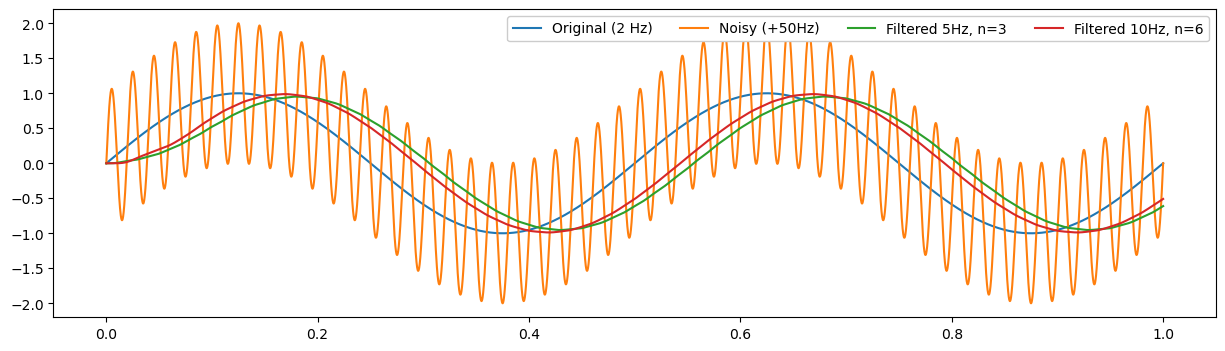

In [11]:
t = np.linspace(0, 1, 10001)

def sin(x, w):
    """ Return a sine wave with frequency w (in Hz). """
    return np.sin(2 * np.pi * w * x)

def low_pass(time, data, f, n=3):
    """
    Emulate an analog Bessel low-pass filter with cut-off f (in Hz).
    
    Returns a tuple ``(t, y)``.
    """
    b, a = scipy.signal.bessel(n, 2 * np.pi * f, analog=True, norm='mag')
    t, y, _ = scipy.signal.lsim((b, a), data, time)
    return t, y

x = sin(t, 2)
y = x + sin(t, 50)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, x, label='Original (2 Hz)')
ax.plot(t, y, label='Noisy (+50Hz)')
ax.plot(*low_pass(t, y, f=5, n=3), label='Filtered 5Hz, n=3')
ax.plot(*low_pass(t, y, f=10, n=6), label='Filtered 10Hz, n=6')
ax.legend(ncol=4, framealpha=1)
plt.show()

Both filters cause quite a phase shift, but otherwise do a great job of reducing the unwanted higher frequencies.

## Applying a digital filter

We can also apply a digital filter.

This time we use:

- Order `n`
- A frequency, _expressed as a fraction of the Nyquist frequency_, which means it's a fraction of _half the sampling frequency_. Yup.
- Analog `False` (the default)
- Norm `mag`, to let Wn set the cut-off frequency

And for the filtering we use [lfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html#scipy.signal.lfilter) instead of lsim (this _applies_ a digital filter to a digital signal, instead of _simulating_ the application of analog filter to an analog signal).

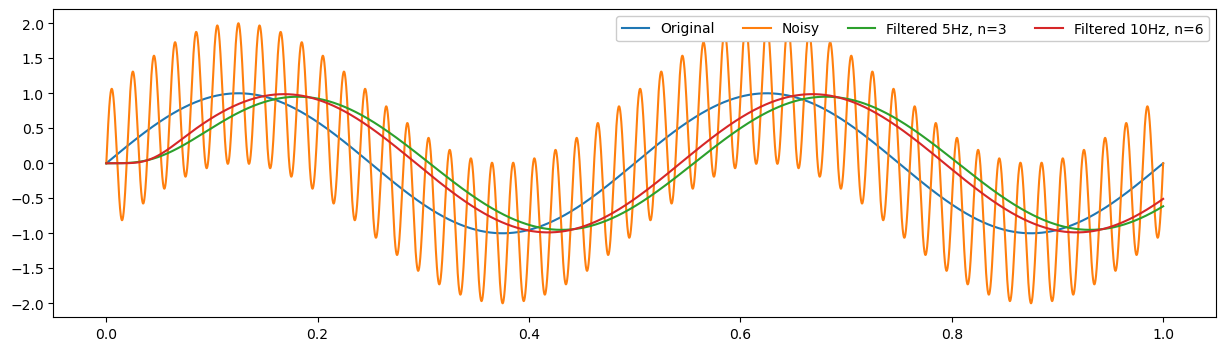

In [12]:
t = np.linspace(0, 1, 10001)
f = 1 / t[1]   # Sampling frequency, in Hz
w = 50         # Cut-off frequency, in Hz

def sin(x, f):
    """ Draw a sine wave with frequency f. """
    return np.sin(2 * np.pi * f * x)

def low_pass(data, f, fs, n=3):
    """ Apply a Bessel low-pass filter with cut-off f (in Hz). """
    # Convert the frequency to a fraction of the Nyquist frequency f/2
    b, a = scipy.signal.bessel(n, f / (fs / 2), norm='mag')
    return scipy.signal.lfilter(b, a, data)

x = sin(t, 2)
y = x + sin(t, 50)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, x, label='Original')
ax.plot(t, y, label='Noisy')
ax.plot(t, low_pass(x, 5, f, n=3), label='Filtered 5Hz, n=3')
ax.plot(t, low_pass(x, 10, f, n=6), label='Filtered 10Hz, n=6')
ax.legend(ncol=4, framealpha=1)
plt.show()

If we're interested in getting the best result (instead of emulating real filters), we can use the method [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) instead. This applies a digital filter "forwards" and then "backwards", meaning it is twice as slow but has (A) zero phase shift and (B) twice the order of the original.

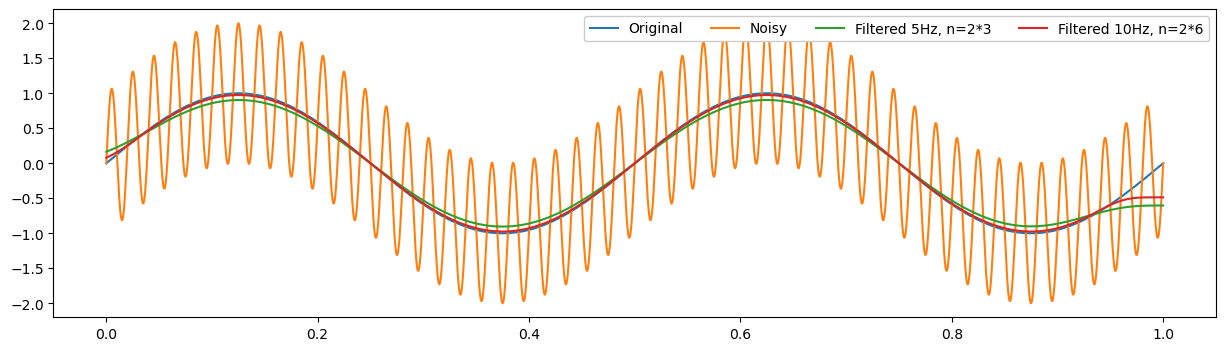

In [13]:
def low_pass(data, f, fs, n=3):
    """ Apply a Bessel low-pass filter with cut-off w (in Hz) twice. """
    b, a = scipy.signal.bessel(n, f / (fs / 2), norm='mag')
    return scipy.signal.filtfilt(b, a, data)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, x, label='Original')
ax.plot(t, y, label='Noisy')
ax.plot(t, low_pass(x, 5, f, n=3), label='Filtered 5Hz, n=2*3')
ax.plot(t, low_pass(x, 10, f, n=6), label='Filtered 10Hz, n=2*6')
ax.legend(ncol=4, framealpha=1)
plt.show()

## Two-pole bessel: the stimulus filter

The HEKA EPC-10 uses a second order Bessel filter in its "stimulus filter", which is applied to voltage steps to reduce capacitative transients.
So we'll have a look at this filter in detail.

First, we'll look at it the conventional way: as a low-pass filter over a _periodic_ signal, analysed in terms of its _frequency response_.

### Frequency response

The standard equation for a 2-pole Bessel is
\begin{align}
H(s) = \frac{3}{s^2 + 3s + 3}
\end{align}

For the _magnitude_ of its frequency response, we find
\begin{align}
|H(i\phi)| = \left| \frac{3}{(i\phi)^2 + 3i\phi + 3} \right| 
           = 3 \left| \frac{1}{3 - \phi^2 + 3\phi i} \right|
\end{align}
To calculate this, we use
\begin{align}
\left| \frac{1}{a + bi} \right|
    = \left| \frac{a - bi}{a^2 + b^2} \right|
    = \sqrt{\frac{a^2 + b^2}{(a^2 + b^2)^2}}
    = \frac{1}{\sqrt{a^2 + b^2}}
\end{align}
for
\begin{align}
|H(i\phi)| = \frac{3}{\sqrt{(3 - \phi^2)^2 + 9\phi^2}}
           = \frac{3}{\sqrt{\phi^4 + 3\phi^2 + 9}}
\end{align}

The frequency at which this filter's gain is $1/\sqrt(2)$ (the 3dB point) is found from:
\begin{align}
\frac{3}{\sqrt{\phi^4 + 3\phi^2 + 9}} &= \frac{1}{\sqrt{2}} \\
\sqrt{\phi^4 + 3\phi^2 + 9} &= 3\sqrt{2}\\
\phi^4 + 3\phi^2 - 9 &= 0 \\
\phi^2 = \frac{-3 \pm \sqrt{9 + 4\cdot9}}{2} &= \frac{3}{2}\left(-1 \pm \sqrt{5} \right) \\
\phi = \pm \sqrt{\frac{3}{2}\left(-1 \pm \sqrt{5} \right)}
\end{align}
By only allowing real and positive numbers, this becomes a single solution, which we'll call $\omega_0$:
\begin{align}
\omega_0 = \sqrt{\frac{3}{2}\left(-1 + \sqrt{5} \right)} \approx 1.36
\end{align}



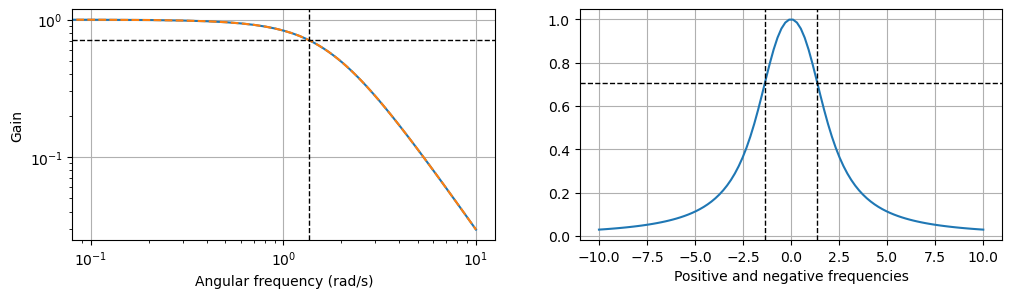

In [14]:
w = np.linspace(0, 10, 100)

fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(hspace=0.2)

# Make a log-log plot, as used in a Bode diagram
ax = fig.add_subplot(1, 2, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Gain')
ax.set_xlabel('Angular frequency (rad/s)')
ax.grid()
    
# Plot, letting Numpy work out the absolute value
ax.plot(w, np.abs(3 / ((w*1j)**2 + 3*(w*1j) + 3)))
    
# Plot, using the equation we derived
ax.plot(w, 3 / np.sqrt(w**4 + 3*w**2 + 9), '--')

# Draw lines for w=w0 and gain=1/sqrt(2)
kw = dict(color='k', lw=1, ls='--')
ax.axhline(1 / np.sqrt(2), **kw)
ax.axvline(np.sqrt(3/2 * (np.sqrt(5) - 1)), **kw)

# Show "negative frequencies", in an unscaled plot
w = np.linspace(-10, 10, 100)
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Positive and negative frequencies')
ax.grid()
ax.plot(w, 3 / np.sqrt(w**4 + 3*w**2 + 9))
ax.axhline(1 / np.sqrt(2), **kw)
ax.axvline(np.sqrt(3/2 * (np.sqrt(5) - 1)), **kw)
ax.axvline(-np.sqrt(3/2 * (np.sqrt(5) - 1)), **kw)
plt.show()

Now, we scale the filter to place this point at a user-defined cut-off frequency $\omega_c=10\,\text{kHz}=2\cdot10^4/\pi\,\text{rad}/\text{s}$:

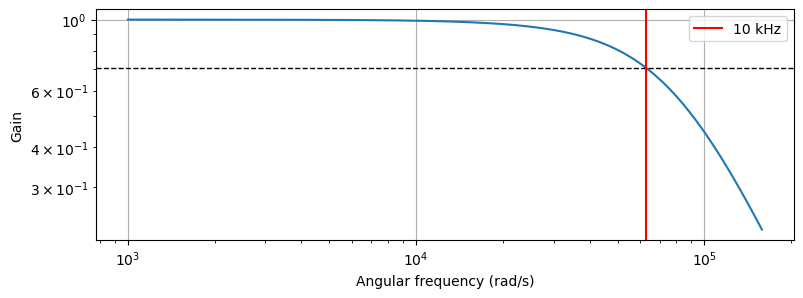

In [15]:
w = np.logspace(3, 5.2, 1000)
w0 = np.sqrt(3 / 2 * (np.sqrt(5) - 1))
z = w * w0 / (2e4 * np.pi)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Gain')
ax.set_xlabel('Angular frequency (rad/s)')
ax.grid()
ax.plot(w, 3 / np.sqrt(z**4 + 3*z**2 + 9))
kw = dict(color='k', lw=1, ls='--')
ax.axhline(1 / np.sqrt(2), **kw)
ax.axvline(2e4 * np.pi, color='r', label='10 kHz')
ax.legend()
plt.show()

### Step response and rise time

The HEKA stimulus filter is described as having a [rise time](https://en.wikipedia.org/wiki/Rise_time) of either 20$\mu$s or 2$\mu$s.
See e.g. the EPC-10 hardware manual:

> Two degrees of filtering, specified as the rise times (time from 10% to 90% of the amplitude of a step change) are available in the
software: 2 µs, which is the minimum required to avoid non-linearity in the internal circuitry, and 20 µs, which is preferable for all but the fastest measurements, to reduce the capacitive transients

To find the transfer function scalings for these settings, we start by working out the _step response_:


From [Appendix A2](./appendix-A2-laplace-and-filters) we get the step function and its Laplace transform
\begin{align}
u(t) = \delta(t) && U(s) = \frac{1}{s}
\end{align}
for output
\begin{align}
Y(s) = H(s)U(s) = \frac{3}{s(s^2 + 3s + 3)}
\end{align}

To solve this, we split into partial coefficients while keeping the second-order term together:

\begin{align}
Y(s) = \frac{3}{s(s^2 + 3s + 3)} 
     = \frac{A}{s} + \frac{B + Cs}{s^2 + 3s + 3}
\end{align}

\begin{align}
3 &= A(s^2 + 3s + 3) + Bs + Cs^2 \\
  &= (A + C)s^2 + (3A + B)s + 3A
\end{align}
\begin{align}
A = 1 && B = -3 && C = -1
\end{align}

\begin{align}
Y(s) = \frac{1}{s} + \frac{-3 - s}{s^2 + 3s + 3}
     = \frac{1}{s} - \frac{3 + s}{s^2 + 3s + 3}
\end{align}

To save time, we could also have [asked a website](https://www.wolframalpha.com/input?i=partial+fractions+3%2F%28s%28s%5E2+%2B+3s+%2B+3%29%29) or used [SymPy](https://docs.sympy.org/latest/modules/polys/reference.html#sympy.polys.partfrac.apart):

In [16]:
from sympy.polys.partfrac import apart
from sympy.abc import s

apart(3 / (s * (s**2 + 3 * s + 3)))

-(s + 3)/(s**2 + 3*s + 3) + 1/s

To get the inverse transform, we can write this in pole-zero form:
\begin{align}
Y(s) = \frac{1}{s} - \frac{3 + s}{(s + \sigma - i\omega)(s + \sigma + i\omega)},
&& \sigma = 3/2,
&& \omega = \sqrt{3}/2
\end{align}

This has the advantage that we can look up the standard solution, e.g. in [Appendix A2](./appendix-A2-laplace-and-filters)
\begin{align}
F(s) &= \frac{C_1 + C_2 s}{(s + \sigma - i\omega)(s + \sigma + i\omega)} \\
f(t) &= \left( \frac{C_1 - C_2\sigma}{\omega}e^{-\sigma t} \sin(\omega t) + C_2 e^{-\sigma t} \cos(\omega t) \right) \theta(t)
\end{align}

to find
\begin{align}
y(t) &= \theta(t) - \left( \frac{C_1 - C_2\sigma}{\omega}e^{-\sigma t} \sin(\omega t) + C_2 e^{-\sigma t} \cos(\omega t) \right) \theta(t) \\
&= \theta(t) \left[1 - \frac{3 - 3/2}{\sqrt{3}/2}e^{-3/2t} \sin(\sqrt{3}/2 t) + e^{-3/2 t} \cos(\sqrt{3}/2 t) \right] \\
&= \theta(t) \left[1 - (\sqrt{3} \sin(\sqrt{3}/2 t) + \cos(\sqrt{3}/2 t))e^{-3/2t} \right]
\end{align}

Let's plot it:

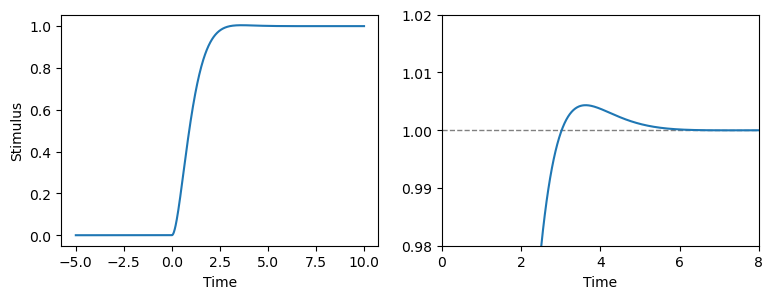

In [17]:
t = np.linspace(-5, 10, 1000)

def bessel2_step(t):
    theta = 1 * (t >= 0)
    s = np.sqrt(3)
    return theta * (1 - (s * np.sin(s/2*t) + np.cos(s/2*t)) * np.exp(-3/2*t))

y = bessel2_step(t)

fig = plt.figure(figsize=(9, 3))
fig.subplots_adjust(hspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.update(dict(xlabel='Time', ylabel='Stimulus'))
ax.plot(t, y)
ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Time')
ax.axhline(1, color='grey', ls='--', lw=1)
ax.plot(t, y)
ax.set_xlim(0, 8)
ax.set_ylim(0.98, 1.02)
plt.show()

This looks good! And we can see the near lack of overshoot that makes Bessel filters popular.

We can use the equations above to work out the rise time, but it's probably not a lovely expression so we'll just do it numerically:

0.2999218750000007 0.10001114060500294
1.8783203124999999 0.8999978202201413


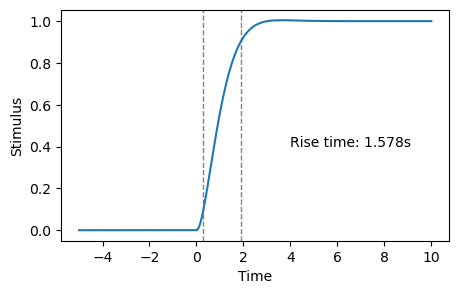

In [18]:
from scipy.optimize import fmin
t10 = fmin(lambda x: (bessel2_step(x) - 0.1)**2, 0.1, disp=False)[0]
t90 = fmin(lambda x: (bessel2_step(x) - 0.9)**2, 2, disp=False)[0]
print(t10, bessel2_step(t10))
print(t90, bessel2_step(t90))
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot()
ax.update(dict(xlabel='Time', ylabel='Stimulus'))
ax.axvline(t10, color='grey', ls='--', lw=1)
ax.axvline(t90, color='grey', ls='--', lw=1)
ax.plot(t, y)
ax.text(4, 0.4, f'Rise time: {t90 - t10:.4}s')
plt.show()

To emulate a rise time of 20$\mu$s, we scale $t$:

0.0038124999999999843 0.10029671636557969
0.0238125 0.8996055239892486


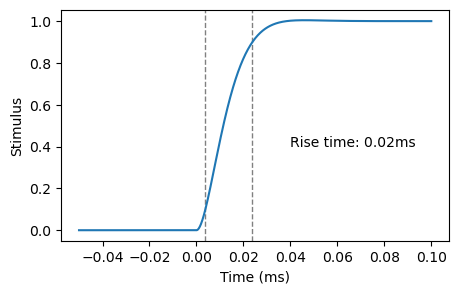

In [19]:
t = np.linspace(-0.05, 0.1, 1000)

def bessel2_step(t, x):
    theta = 1 * (t >= 0)
    s = np.sqrt(3)
    t = t / 2 * x
    return theta * (1 - (s * np.sin(s*t) + np.cos(s*t)) * np.exp(-3*t))

f = 78.8
y = bessel2_step(t, f)

t10 = fmin(lambda x: (bessel2_step(x, f) - 0.1)**2, 0.01, disp=False)[0]
t90 = fmin(lambda x: (bessel2_step(x, f) - 0.9)**2, 0.02, disp=False)[0]
print(t10, bessel2_step(t10, f))
print(t90, bessel2_step(t90, f))

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot()
ax.update(dict(xlabel='Time (ms)', ylabel='Stimulus'))
ax.axvline(t10, color='grey', ls='--', lw=1)
ax.axvline(t90, color='grey', ls='--', lw=1)
ax.plot(t, y)
ax.text(0.04, 0.4, f'Rise time: {t90 - t10:.4}ms')
plt.show()

### Does this match what we measure?

The HEKA EPC-9 has a [paper describing its hardware](), which contains a nice block diagram (Fig 1).
This shows us that

1. The stimulus filter is applied to the command potential before any other additions (e.g. Cm and Rs compensation)
2. The "V monitor" is read directly from the stimulus filter output, again without any interference from other components.

As a result, we should be able to see the effects of the stimulus filter on a recorded "V monitor" signal.
Here's a recording made using an EPC-10:

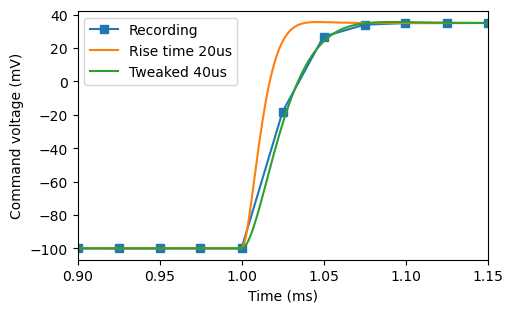

In [20]:
import myokit
d = myokit.DataLog.load('resources/rise_time_20us.zip')
d = d.npview()

fig = plt.figure(figsize=(5, 3))
fig.subplots_adjust(0.14, 0.15, 0.96, 0.98)
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Command voltage (mV)')

ax.plot(d.time(), d['vfiltered'], 's-', label='Recording')

t = np.linspace(0, 2, 2000)
y = -100 + 135 * bessel2_step(t - 1, 78.8)
ax.plot(t, y, label='Rise time 20us')
y = -100 + 135 * bessel2_step(t - 1, 78.8 / 2)
ax.plot(t, y, label='Tweaked 40us')

ax.legend()
ax.set_xlim(0.9, 1.15)
plt.show()

In [21]:
f = 40
t10 = fmin(lambda x: (bessel2_step(x, f) - 0.1)**2, 0.01, disp=False)[0]
t90 = fmin(lambda x: (bessel2_step(x, f) - 0.9)**2, 0.02, disp=False)[0]
assert abs(bessel2_step(t10, f) - 0.1) < 1e-2
assert abs(bessel2_step(t90, f) - 0.9) < 1e-2
print(t90 - t10)

0.03943750000000005


It seems the rise time is roughly twice what is advertised.

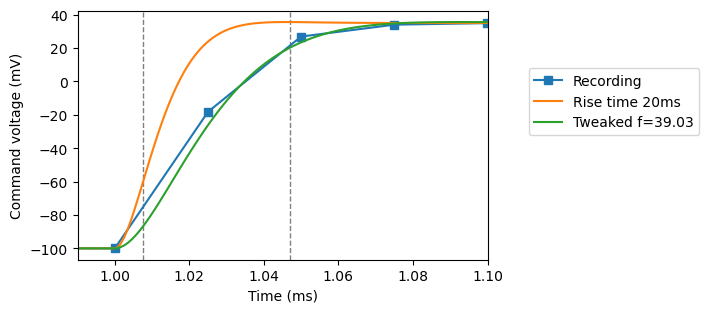

In [22]:
fig = plt.figure(figsize=(5, 3))
fig.subplots_adjust(0.14, 0.15, 0.96, 0.98)
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Command voltage (mV)')

ax.axvline(1 + t10, color='grey', lw=1, ls='--')
ax.axvline(1 + t90, color='grey', lw=1, ls='--')
ax.plot(d.time(), d['vfiltered'], 's-', label='Recording')

t = np.linspace(0, 2, 2000)
y = -100 + 135 * bessel2_step(t - 1, 78.8)
ax.plot(t, y, label='Rise time 20ms')

f = fmin(lambda f: np.sum((bessel2_step(d.time() - 1, f) - d['vfiltered'])**2), 40, disp=False)[0]
y = -100 + 135 * bessel2_step(t - 1, f)
ax.plot(t, y, label=f'Tweaked f={f:.4}')

ax.legend(loc=(1.1, 0.5))
ax.set_xlim(0.99, 1.1)
plt.show()

There is no "official" definition of "rise time", so we can try with other numbers:

In [23]:
f = 40
def rise(p1, p2):
    t1 = fmin(lambda x: (bessel2_step(x, f) - p1)**2, 0.01, disp=False)[0]
    t2 = fmin(lambda x: (bessel2_step(x, f) - p2)**2, 0.02, disp=False)[0]
    assert abs(bessel2_step(t1, f) - p1) < 1e-2
    assert abs(bessel2_step(t2, f) - p2) < 1e-2
    return t2 - t1

print(rise(0.2, 0.8))
print(rise(0.25, 0.75))
print(rise(0.30, 0.7))

0.02631250000000002
0.021187500000000015
0.01656250000000001


So none of the obvious choices match, and it looks more like the rise time is just twice what it's said to be.

### Can we use a first order approximation for the stimulus filter?

The 2-pole Bessel was easy enough to implement, but having 2 state variables is maybe a bit over the top.
What does it look like if we approximate with a single-order filter?

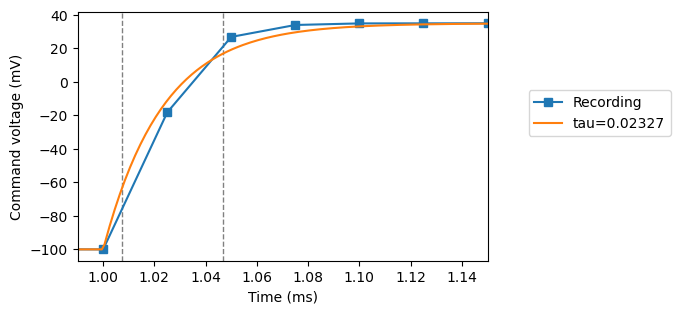

In [25]:
def y(t, tau):
    t[t < 0] = 0
    return 35 + (-100 - 35) * np.exp(-t / tau)

tau = fmin(lambda tau: np.sum((y(d.time() - 1, tau) - d['vfiltered'])**2), 0.02, disp=False)[0]

fig = plt.figure(figsize=(5, 3))
fig.subplots_adjust(0.14, 0.15, 0.96, 0.98)
ax = fig.add_subplot()
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Command voltage (mV)')

ax.axvline(1 + t10, color='grey', lw=1, ls='--')
ax.axvline(1 + t90, color='grey', lw=1, ls='--')
ax.plot(d.time(), d['vfiltered'], 's-', label='Recording')

t = np.linspace(0, 2, 2000)
ax.plot(t, y(t - 1, tau), label=f'tau={tau:.4}')
ax.legend(loc=(1.1, 0.5))
ax.set_xlim(0.99, 1.15)
plt.show()

This is not far off at all, and any discrepancies only last for 0.1ms. Compared to e.g. fast-capacitance compensation, it is unlikely that approximating as first order will cause any problems.